In [1]:
%reload_ext autoreload
%autoreload 2
import slap2_py as spy
import wisco_slap as wis
import wisco_slap.defs as DEFS
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import matplotlib as mpl
import h5py
import glob
import polars as pl
from pathlib import Path
import tifffile
import seaborn as sns
import electro_py as epy
import cv2

In [4]:
subject = 'kaus'
exp = 'exp_1'
sb = 1
locs = ['loc_E']
loc = 'loc_E'
acq = 'acq_1'

In [8]:
sdf = load_syndf(subject, exp, loc, acq, filters={'group': 'dF',
                                                  'type': 'matchFilt',
                                                  'channel': 2})

In [9]:
sdf_full = load_syndf(subject, exp, loc, acq, filters={})

In [5]:
esum_path = wis.util.io.sub_esum_path(subject, exp, loc, acq)

In [105]:
lsdf = wis.scope.io.load_lsdf(subject, exp, loc, acq, apply_ephys_offset=True)

In [126]:
t1 = 1910
t2 = t1 + 10

In [137]:
dd = lsdf.filter(pl.col('time').is_between(t1, t2)).filter(pl.col('dmd')==2).filter(pl.col('source')==0).filter(pl.col('channel')==2)['data'].to_numpy()

In [139]:
# check if there are any nan values in the array
np.isnan(dd).sum()

# set those nan values to zero
# dd may be a read-only array; create a writable copy with NaNs replaced
dd = np.nan_to_num(dd, copy=True, nan=0.0)

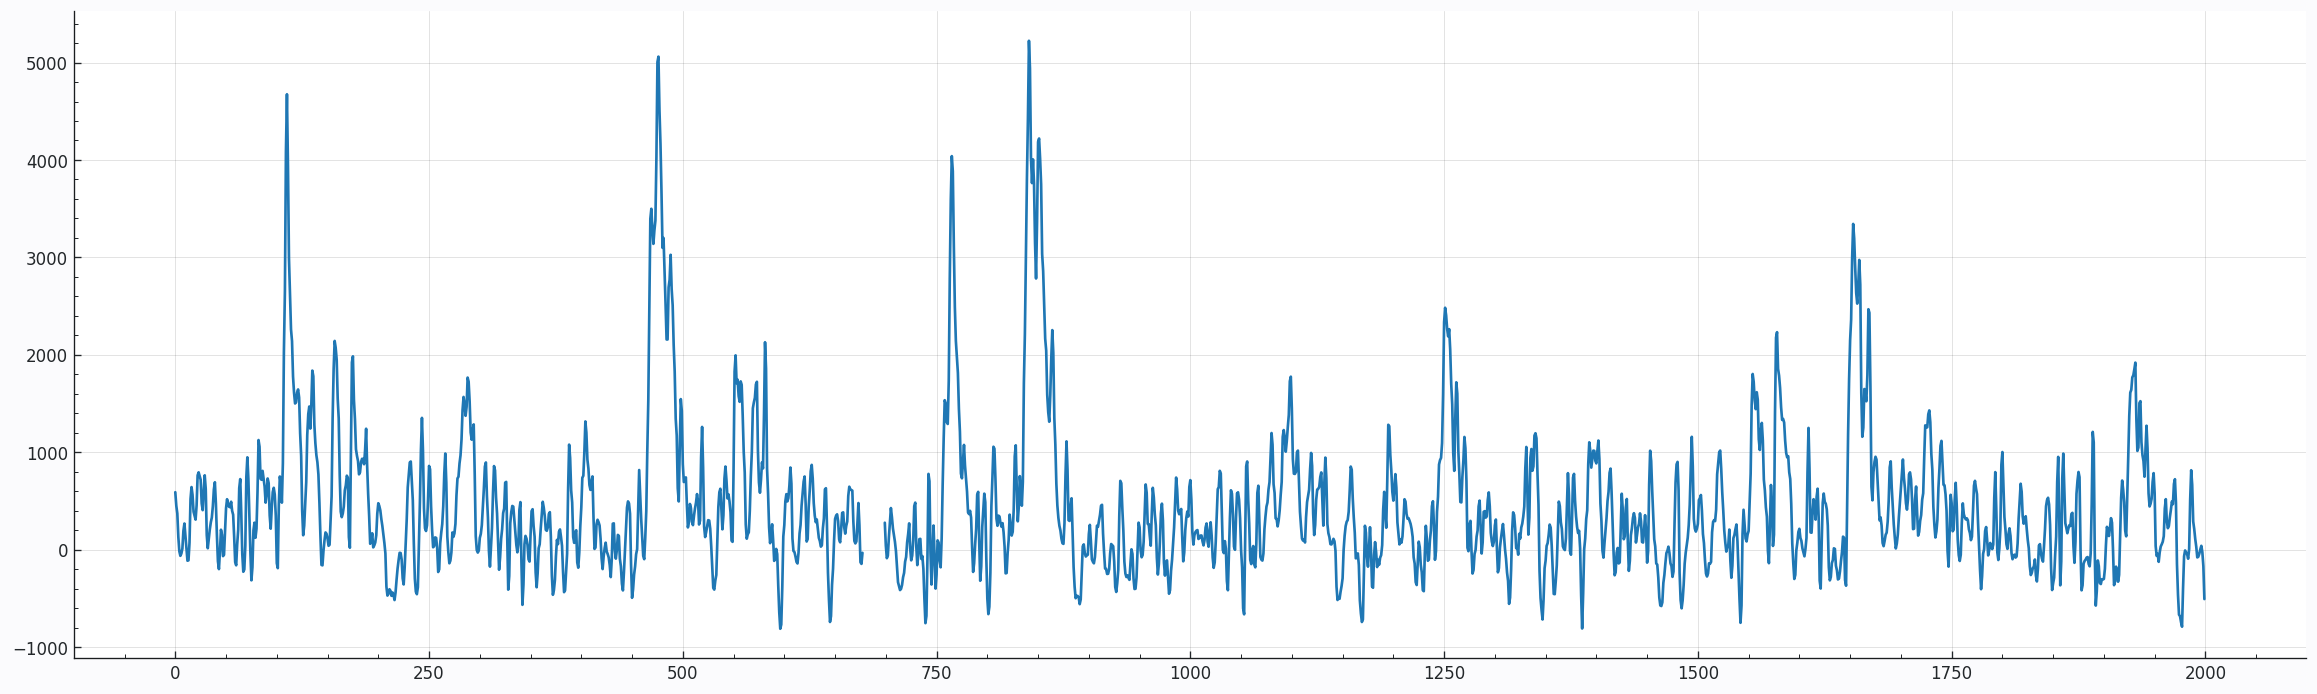

In [128]:
f, ax = plt.subplots(1, 1, figsize=(24, 7))
ax.plot(dd)

In [141]:
path = '/Users/driessen2@ad.wisc.edu/kdriessen/slap_wi_master/ophys-slap2-analysis/sample_data.npy'
np.save(path, dd)

In [3]:
tt = ['matchFilt', 'events']
soma_dfs = []
for loc in locs:
    soma_df = wis.scope.io.load_roidf(subject, exp, loc, acq, apply_ephys_offset=True)
    soma_dfs.append(soma_df)
sdf = pl.concat(soma_dfs)
syndfs = []
for loc in locs:
    syndf = wis.scope.io.load_syndf(subject, exp, loc, acq, trace_types=tt, apply_ephys_offset=True)
    syndfs.append(syndf)
syndf = pl.concat(syndfs)
sdf = sdf.sort('time', descending=False)
syndf = syndf.sort('time', descending=False)

In [69]:
mf = syndf.filter(pl.col('trace_type') == 'matchFilt')
ev = syndf.filter(pl.col('trace_type') == 'events')

In [66]:
f0 = spy.hf.hcore.load_f0_full_helper(esum_path)

In [ ]:
def detect_events(df):
    # Placeholder for event detection logic
    assert len(df['trace_type'].unique() == 1), "DataFrame must contain only one trace type"
    trace_type = df['trace_type'][0]
    if trace_type == 'matchFilt':
        _run_matchfilt_event_detection(df)
    elif trace_type == 'events':
        _run_events_event_detection(df)
    else:
        raise ValueError(f"Unknown trace type: {trace_type}")

In [ ]:
noise_mf = spy.hf.hcore.load_noise_estimates(esum_path, group='dF', ttype='matchFilt')
noise_ev = spy.hf.hcore.load_noise_estimates(esum_path, group='dF', ttype='events')
ntrials = len(noise_mf[1])

In [ ]:
trial_shape = spy.hf.hcore.get_trial_shape(esum_path, dmd=1, key='F0')
len_trial = trial_shape[1]

In [17]:
unique_times = mf.filter(pl.col('dmd')==1).filter(pl.col('source')==0)['time'].to_numpy()

In [70]:
trial_labels = []
for ti in range(299):
    labels_for_trial = np.ones(len_trial) * ti
    trial_labels.append(labels_for_trial)
trial_labels = np.concatenate(trial_labels)
trial_labels
trial_df = pl.DataFrame({'time': unique_times, 'trial': trial_labels})
mf = mf.join(trial_df, on='time')
ev = ev.join(trial_df, on='time')

In [72]:
np.sqrt(noise_vals)

array([ 71.75540965, 220.09061998,  53.05934348,  65.60051296,
       182.10617901,  96.50883969,  84.14071391,  51.55813625,
        61.00854903, 102.24466884, 116.13197534,  47.35563468,
        34.55338905,  81.63493756,  64.36988095,  48.72469074,
        44.73857573,  70.8599603 ,  63.32848129,  79.34002582,
        62.46595672,  54.75813777,  87.75861059,  58.84776438,
        48.79889242,  54.91393201,  70.51002252,  73.23065808,
        70.214749  ,  65.84018089,  64.94379526,  79.43801103,
        82.90036159,  74.37383379,  40.43522121,  50.51249741,
        58.67641944,  63.83645381,  66.0272856 ,  54.15894898,
        57.53191522,  55.76967469,  52.87685364,  56.34616077,
        58.73836192,  57.87011027,  33.69525837,  28.34655632,
        58.36651365,  43.06110008,  52.02538478,  26.9920523 ,
        68.75819993,  39.54842568,  22.98407892,  47.80981766,
        51.49771129,  40.67366966,  32.46782846,  38.07671388,
        47.38327281,  50.36666739,  44.27701933,  33.03

In [ ]:
noise_dfs = []
for dmd in [1, 2]:
    nest = noise_mf[dmd]
    for trial in range(ntrials):
        noise_vals = nest[trial].flatten()
        std = np.sqrt(noise_vals)
        std3 = 3 * std
        sources = np.arange(len(noise_vals))
        source = pl.Series('source', sources)
        tdf = pl.DataFrame({'source': source,
                            'trial': trial,
                            'noise_est': std,
                            'noise_est_3sd': std3,
                            'dmd': dmd})
        noise_dfs.append(tdf)
noise_df = pl.concat(noise_dfs)
noise_df = noise_df.with_columns(pl.col('trial').cast(pl.Float64))
mf = mf.join(noise_df, on=['source', 'trial', 'dmd'])
mf = mf.with_columns(noise_5sd = pl.col('noise_est') * 5)

In [83]:
noise_dfs = []
for dmd in [1, 2]:
    nest = noise_ev[dmd]
    for trial in range(ntrials):
        noise_vals = nest[trial].flatten()
        std = np.sqrt(noise_vals)
        std3 = 3 * std
        sources = np.arange(len(noise_vals))
        source = pl.Series('source', sources)
        tdf = pl.DataFrame({'source': source,
                            'trial': trial,
                            'noise_est': std,
                            'noise_est_3sd': std3,
                            'dmd': dmd})
        noise_dfs.append(tdf)
noise_df = pl.concat(noise_dfs)
noise_df = noise_df.with_columns(pl.col('trial').cast(pl.Float64))
ev = ev.join(noise_df, on=['source', 'trial', 'dmd'])
ev = ev.with_columns(noise_5sd = pl.col('noise_est') * 5)

In [58]:
spy.plot.slap_style(version='fig')

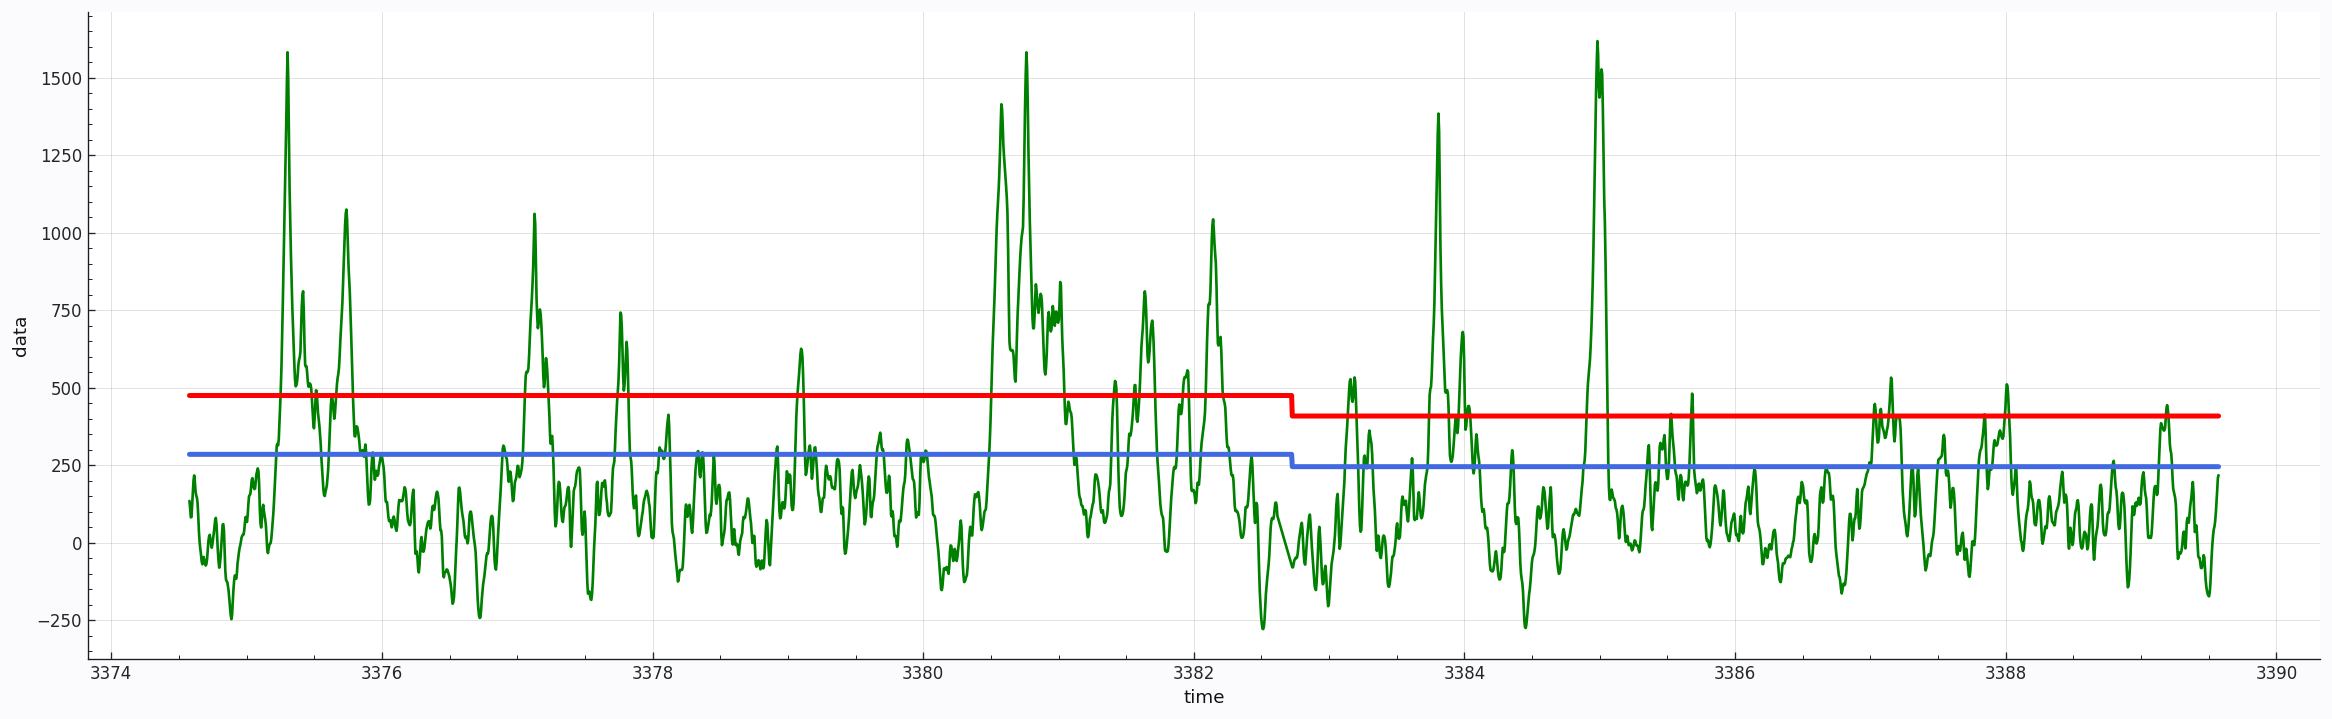

In [85]:
t_start = 1874.5776
t1 = t_start+1500
t2 = t1 + 15
dmd = 2
source_to_plot = 0

d2p = mf.filter((pl.col('dmd')==dmd) & (pl.col('source')==source_to_plot)).filter((pl.col('time')>=t1) & (pl.col('time')<t2))
f, ax = plt.subplots(1, 1, figsize=(24, 7))
ax = sns.lineplot(data=d2p, x='time', y='data', ax=ax, color='green')
ax = sns.lineplot(data=d2p, x='time', y='noise_est_3sd', ax=ax, color='royalblue', linewidth=3)
ax = sns.lineplot(data=d2p, x='time', y='noise_5sd', ax=ax, color='red', linewidth=3)

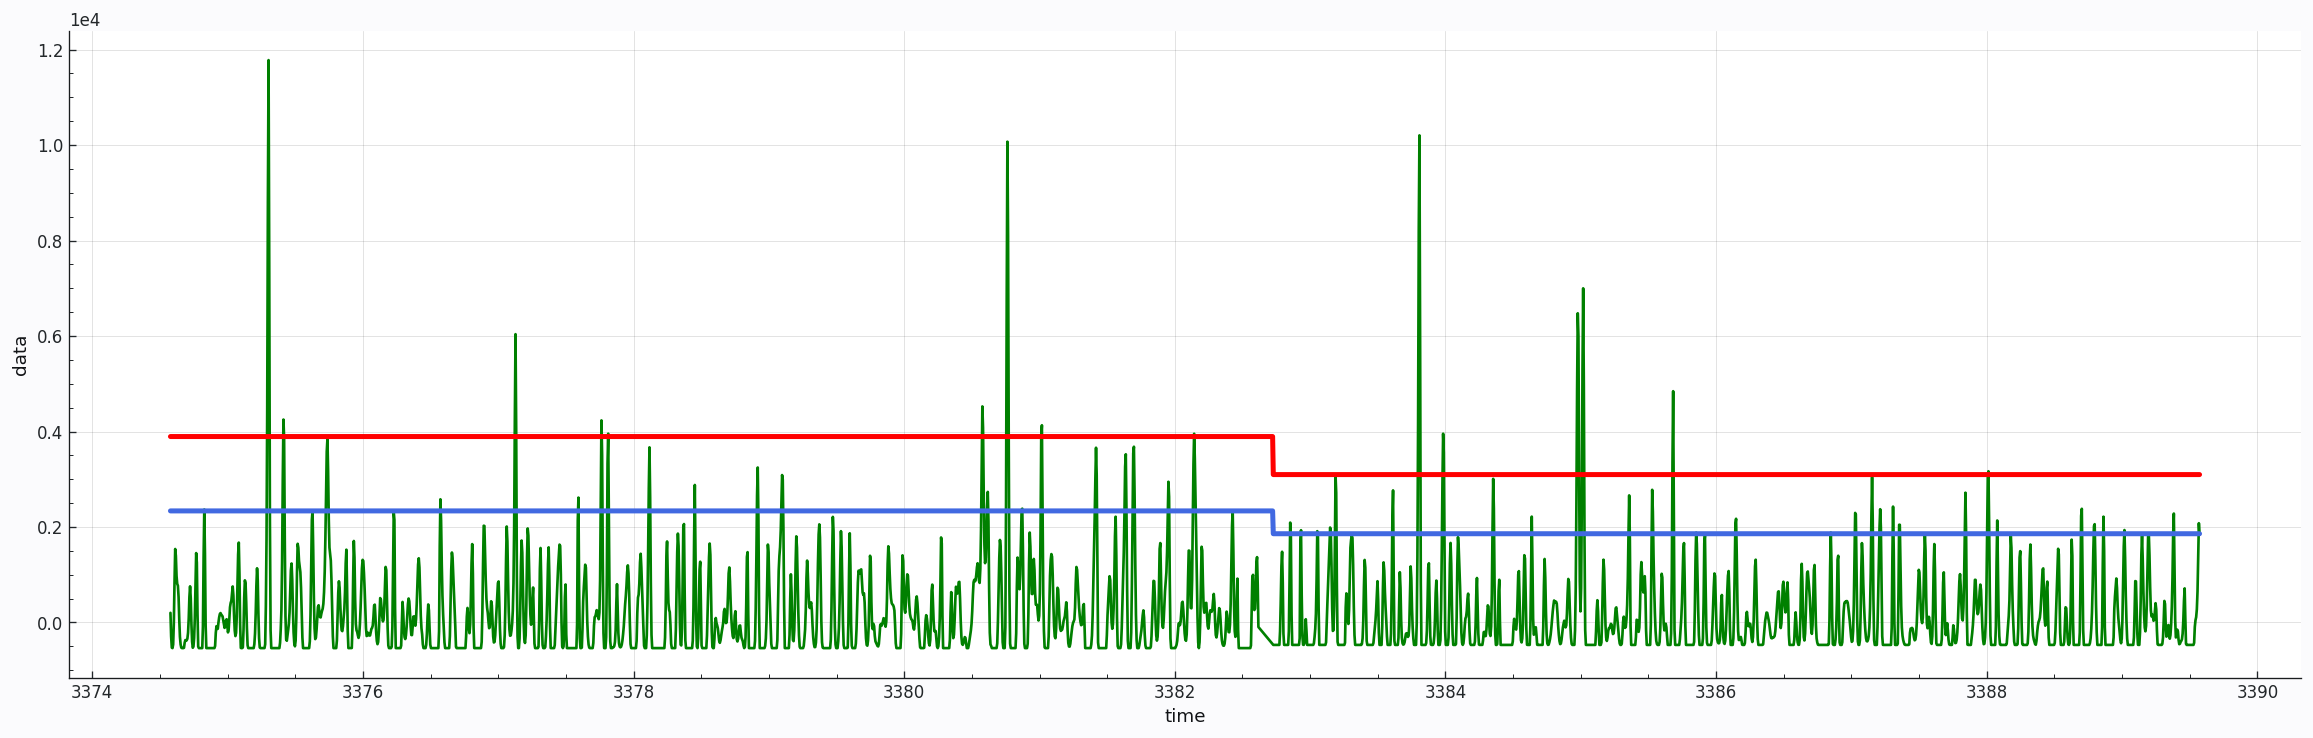

In [86]:
t_start = 1874.5776
t1 = t_start+1500
t2 = t1 + 15
dmd = 2
source_to_plot = 0

d2p = ev.filter((pl.col('dmd')==dmd) & (pl.col('source')==source_to_plot)).filter((pl.col('time')>=t1) & (pl.col('time')<t2))
f, ax = plt.subplots(1, 1, figsize=(24, 7))
ax = sns.lineplot(data=d2p, x='time', y='data', ax=ax, color='green')
ax = sns.lineplot(data=d2p, x='time', y='noise_est_3sd', ax=ax, color='royalblue', linewidth=3)
ax = sns.lineplot(data=d2p, x='time', y='noise_5sd', ax=ax, color='red', linewidth=3)

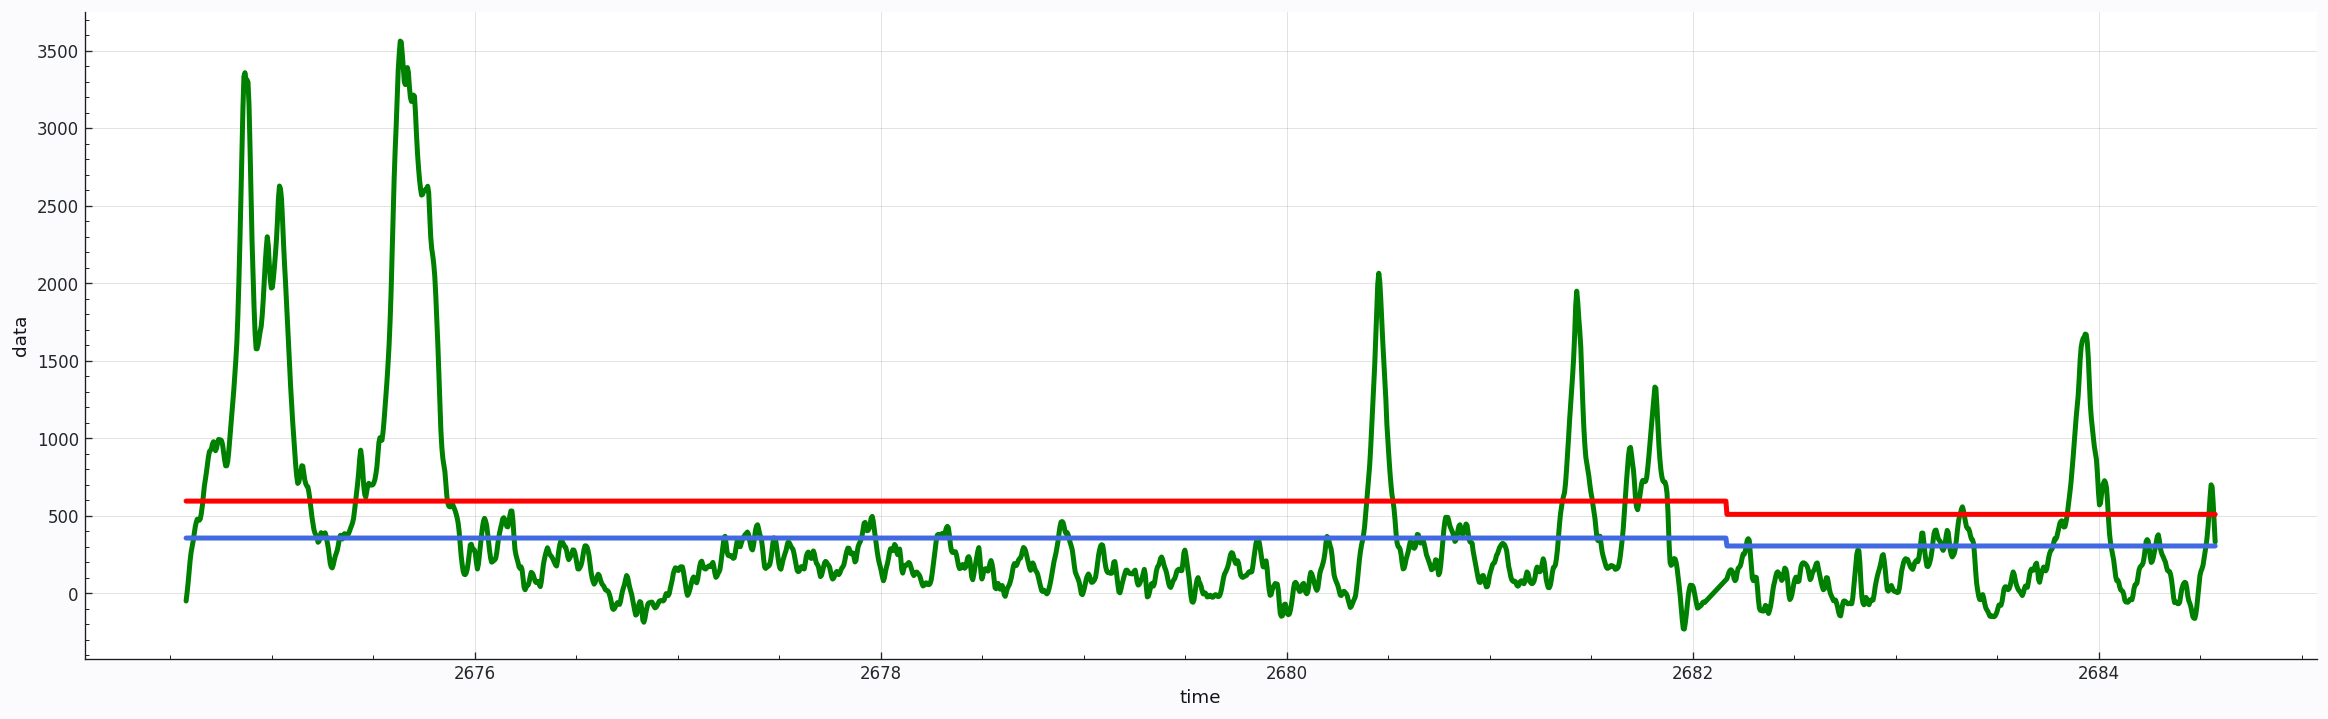

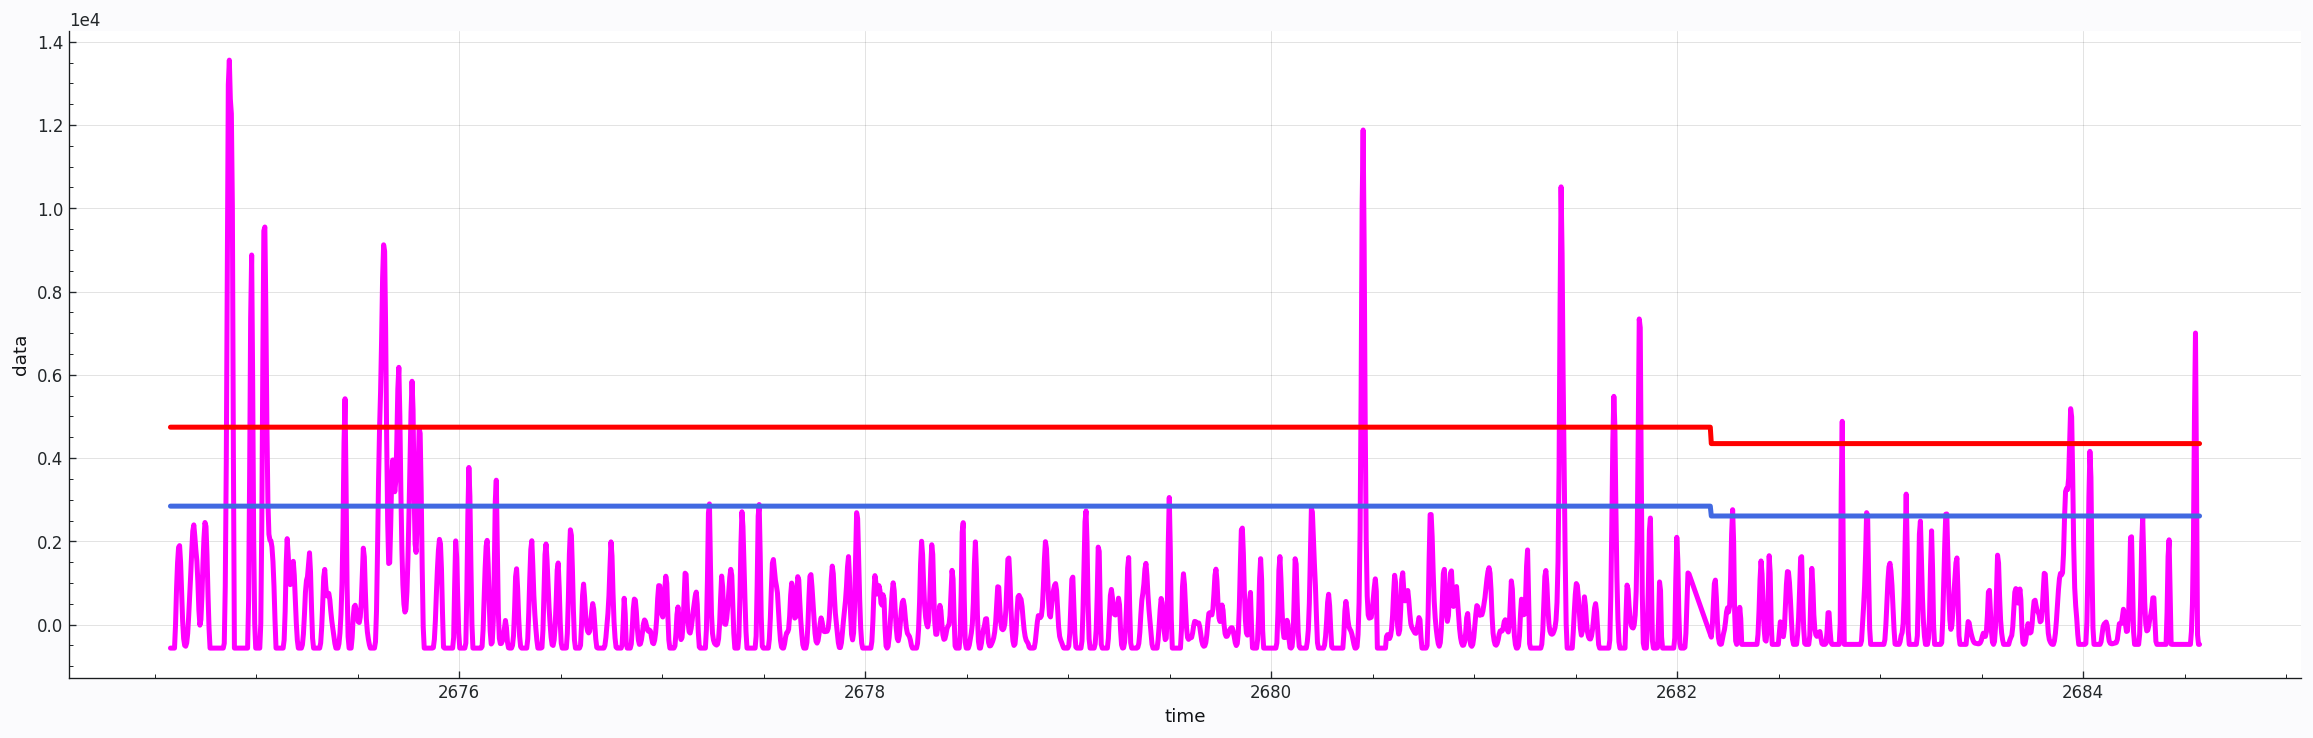

In [92]:
t_start = 1874.5776
t1 = t_start+800
t2 = t1 + 10
dmd = 2
source_to_plot = 0

d2p = mf.filter((pl.col('dmd')==dmd) & (pl.col('source')==source_to_plot)).filter((pl.col('time')>=t1) & (pl.col('time')<t2))
f, ax = plt.subplots(1, 1, figsize=(24, 7))
ax = sns.lineplot(data=d2p, x='time', y='data', ax=ax, color='green', linewidth=3)
ax = sns.lineplot(data=d2p, x='time', y='noise_est_3sd', ax=ax, color='royalblue', linewidth=3)
ax = sns.lineplot(data=d2p, x='time', y='noise_5sd', ax=ax, color='red', linewidth=3)
plt.show()
d2p = ev.filter((pl.col('dmd')==dmd) & (pl.col('source')==source_to_plot)).filter((pl.col('time')>=t1) & (pl.col('time')<t2))
f, ax = plt.subplots(1, 1, figsize=(24, 7))
ax = sns.lineplot(data=d2p, x='time', y='data', ax=ax, color='magenta', linewidth=3)
ax = sns.lineplot(data=d2p, x='time', y='noise_est_3sd', ax=ax, color='royalblue', linewidth=3)
ax = sns.lineplot(data=d2p, x='time', y='noise_5sd', ax=ax, color='red', linewidth=3)
plt.show()

In [ ]:
t_start = 1874.5776
t1 = t_start+60
t2 = t1 + 10
dmd = 2

for source_to_plot in np.arange(20):

    d2p = mf.filter((pl.col('dmd')==dmd) & (pl.col('source')==source_to_plot)).filter((pl.col('time')>=t1) & (pl.col('time')<t2))
    f, ax = plt.subplots(1, 1, figsize=(28, 7))
    ax = sns.lineplot(data=d2p, x='time', y='data', ax=ax, color='green', linewidth=3)
    #ax = sns.lineplot(data=d2p, x='time', y='noise_est_3sd', ax=ax, color='royalblue', linewidth=3)
    #ax = sns.lineplot(data=d2p, x='time', y='noise_5sd', ax=ax, color='red', linewidth=3)

    d2p = ev.filter((pl.col('dmd')==dmd) & (pl.col('source')==source_to_plot)).filter((pl.col('time')>=t1) & (pl.col('time')<t2))
    # secondary axes on the same plot
    ax2 = ax.twinx()
    ax2 = sns.lineplot(data=d2p, x='time', y='data', ax=ax2, color='magenta', linewidth=2, alpha=0.7)
    #ax2 = sns.lineplot(data=d2p, x='time', y='noise_est_3sd', ax=ax2, color='royalblue', linewidth=3)
    #ax2 = sns.lineplot(data=d2p, x='time', y='noise_5sd', ax=ax2, color='red', linewidth=3)
    plt.show()

In [ ]:
# create the f0 df
for dmd in [1, 2]:
    f0_dmd = f0[dmd]
    n_sources, n_trials = f0_dmd.shape
    f0_dfs = []
    for trial in range(n_trials):
        

{1: array([[[1611.11005441, 1611.78593714, 1612.46181986, ...,
                    nan,           nan,           nan],
         [2056.47130423, 2056.70107896, 2056.93085367, ...,
                    nan,           nan,           nan],
         [ 459.33287899,  458.93545398,  458.53802899, ...,
                    nan,           nan,           nan],
         ...,
         [ 140.42910785,  140.43379378,  140.43847968, ...,
                    nan,           nan,           nan],
         [ 126.16086404,  126.21568475,  126.27050551, ...,
                    nan,           nan,           nan],
         [ 124.97107758,  124.91138212,  124.85168669, ...,
                    nan,           nan,           nan]],
 
        [[1205.20629883, 1205.15673828, 1205.10900879, ...,
           113.12441254,  113.14258575,  113.1612854 ],
         [1160.81884766, 1160.91064453, 1161.00073242, ...,
           308.29833984,  308.10574341,  307.90545654],
         [ 333.16702271,  333.17947388,  333.1914367

# Detection

In [143]:
mf = mf.with_columns(active = False)

In [145]:
mf = mf.with_columns(pl.when(pl.col('data') > pl.col('noise_5sd')).then(True).otherwise(False).alias('active'))

In [146]:
mf

time,data,dmd,source,trace_group,trace_type,channel,loc,acq,trial,noise_est,noise_est_3sd,noise_5sd,active
f64,f64,i32,i32,str,str,i32,str,str,f64,f64,f64,f64,bool
1874.5776,-278.110239,1,0,"""dF""","""matchFilt""",2,"""loc_E""","""acq_1""",0.0,95.415541,286.246623,477.077705,false
1874.5776,-389.531699,1,1,"""dF""","""matchFilt""",2,"""loc_E""","""acq_1""",0.0,238.373763,715.12129,1191.868817,false
1874.5776,-0.802345,1,2,"""dF""","""matchFilt""",2,"""loc_E""","""acq_1""",0.0,92.389225,277.167676,461.946127,false
1874.5776,52.021198,1,3,"""dF""","""matchFilt""",2,"""loc_E""","""acq_1""",0.0,149.502801,448.508404,747.514007,false
1874.5776,203.442737,1,4,"""dF""","""matchFilt""",2,"""loc_E""","""acq_1""",0.0,111.223788,333.671365,556.118942,false
…,…,…,…,…,…,…,…,…,…,…,…,…,…
4783.8426,NaN,2,98,"""dF""","""matchFilt""",2,"""loc_E""","""acq_1""",298.0,26.395898,79.187695,131.979491,true
4783.8426,NaN,2,99,"""dF""","""matchFilt""",2,"""loc_E""","""acq_1""",298.0,25.821943,77.46583,129.109716,true
4783.8426,NaN,2,100,"""dF""","""matchFilt""",2,"""loc_E""","""acq_1""",298.0,18.070055,54.210165,90.350276,true


In [153]:
t_start = 1874.5776
t1 = t_start+60
t2 = t1 + 180
dmd = 2
source_to_plot = 0

d2p = mf.filter((pl.col('dmd')==dmd) & (pl.col('source')==source_to_plot)).filter((pl.col('time')>=t1) & (pl.col('time')<t2))

raw_data = d2p['data'].to_numpy()
activity_mask = d2p['active'].to_numpy()
active_data = np.where(activity_mask, raw_data, np.nan)

In [156]:
np.isnan(active_data).sum()

np.int64(30455)

In [157]:
len(active_data)

36000

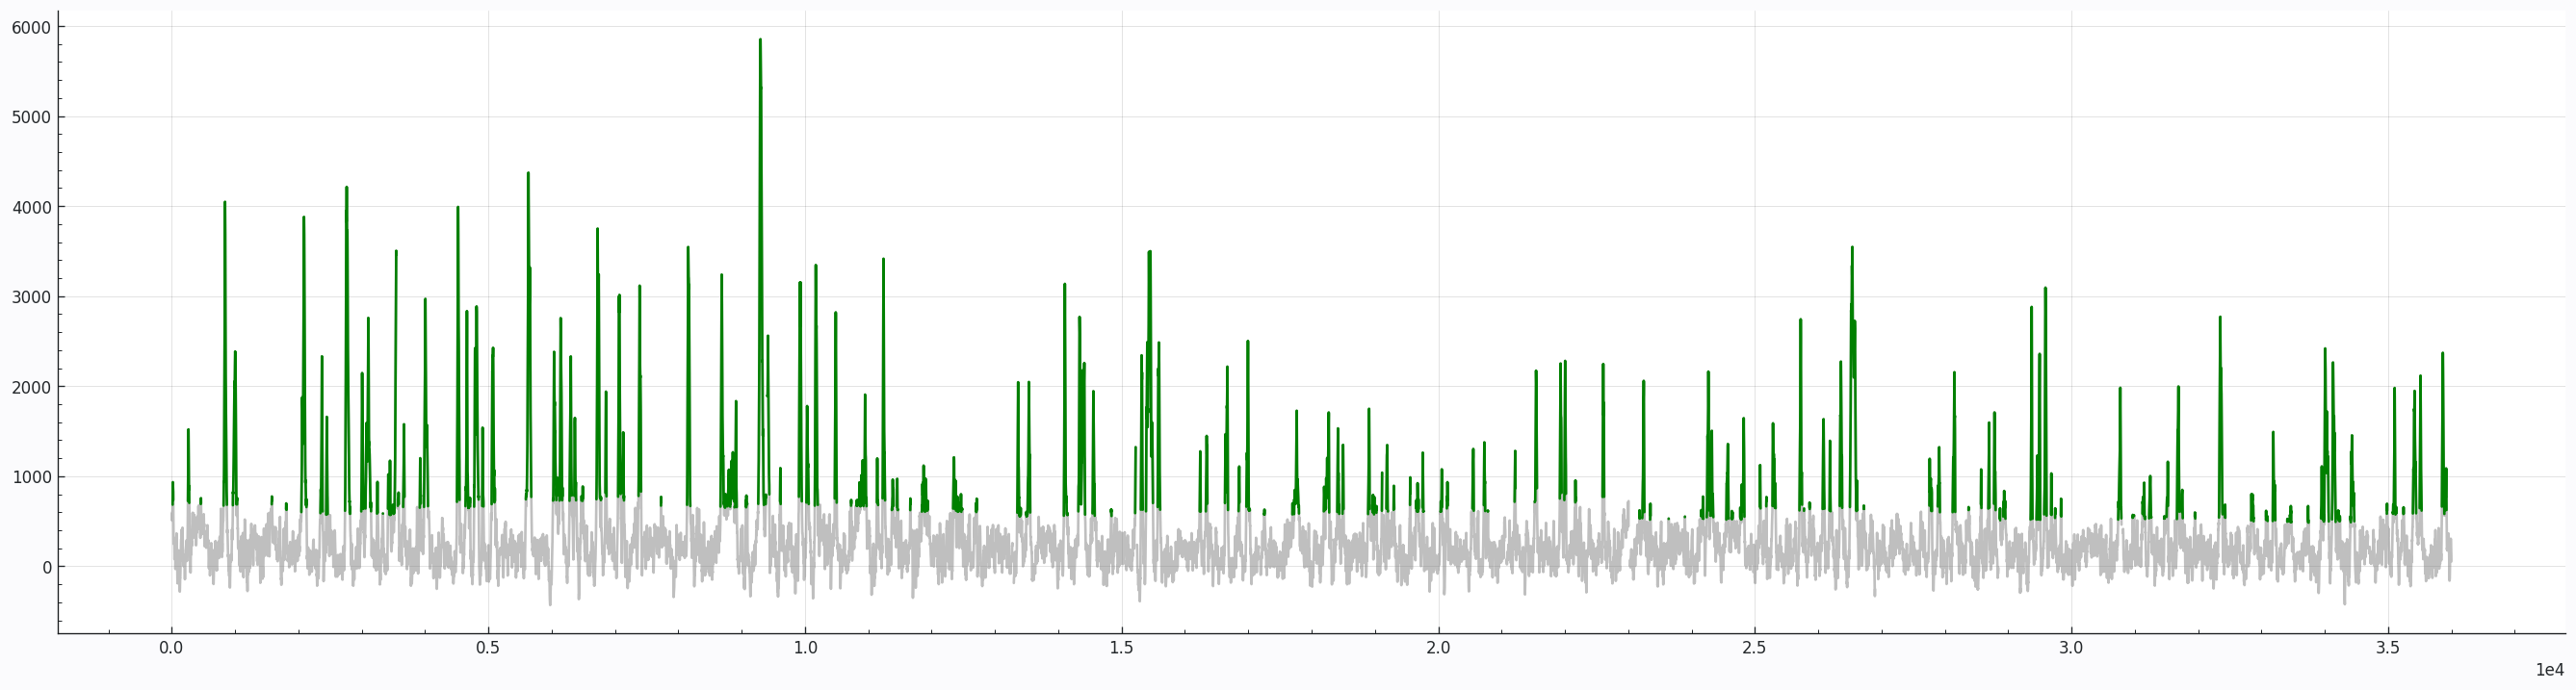

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(28, 7))
ax.plot(raw_data, color='gray', alpha=0.5)
ax.plot(active_data, color='green', alpha=1)

In [158]:
from electro_py.hypno.hypno import get_states_fast

def label_df_with_states(df, h, col='datetime'):
    times = df[col].to_numpy()
    states = get_states_fast(h, times)
    states = np.array(states)
    return df.with_columns(state=pl.lit(states))

In [159]:
h = wis.peri.vig.load_auto_hypno(subject, exp, sb, filter_unclear=0.5, rename=True)

In [161]:
mf = label_df_with_states(mf, h, col='time')

In [175]:
active_sums = mf.group_by(['dmd', 'source', 'state']).agg(pl.col('active').sum())
active_sums = active_sums.sort(['dmd', 'source', 'state'])

In [169]:
total_counts = mf.group_by(['dmd', 'source', 'state']).agg(pl.count())
total_counts = total_counts.sort(['dmd', 'source', 'state'])

/tmp/ipykernel_1254127/1176419940.py:1: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  total_counts = mf.group_by(['dmd', 'source', 'state']).agg(pl.count())


In [174]:
total_counts = total_counts.rename({'count': 'total_counts'})

In [176]:
active_sums = active_sums.join(total_counts, on=['dmd', 'source', 'state'])

In [177]:
active_sums = active_sums.with_columns(
    (pl.col('active') / pl.col('total_counts')).alias('active_ratio')
)

In [178]:
active_sums

dmd,source,state,active,total_counts,active_ratio
i32,i32,str,u32,u32,f64
1,0,"""NREM""",22487,96600,0.232785
1,0,"""REM""",4758,26000,0.183
1,0,"""Wake""",94385,454454,0.207689
1,0,"""unclear""",1311,4800,0.273125
1,1,"""NREM""",2525,96600,0.026139
…,…,…,…,…,…
2,101,"""unclear""",709,4800,0.147708
2,102,"""NREM""",8647,96600,0.089513
2,102,"""REM""",1792,26000,0.068923


In [ ]:
active_sums.filter(pl.col('dmd')==2)

dmd,source,state,active,total_counts,active_ratio
i32,i32,str,u32,u32,f64
2,0,"""NREM""",14625,96600,0.151398
2,0,"""REM""",3580,26000,0.137692
2,0,"""Wake""",64118,454454,0.141088
2,0,"""unclear""",602,4800,0.125417
2,1,"""NREM""",4282,96600,0.044327
…,…,…,…,…,…
2,101,"""unclear""",709,4800,0.147708
2,102,"""NREM""",8647,96600,0.089513
2,102,"""REM""",1792,26000,0.068923


In [181]:
# for each source on each dmd, get the NREM/wake active ratio
active_sums = active_sums.sort(['dmd', 'source', 'state'])

In [184]:
dmds = active_sums.filter(pl.col('state')=='NREM')['dmd']
sources = active_sums.filter(pl.col('state')=='NREM')['source']

In [185]:
rem_ratios = active_sums.filter(pl.col('state')=='REM')['active_ratio'].to_numpy()
nrem_ratios = active_sums.filter(pl.col('state')=='NREM')['active_ratio'].to_numpy()
wake_ratios = active_sums.filter(pl.col('state')=='Wake')['active_ratio'].to_numpy()


In [186]:
nrem_wake_ratio = nrem_ratios / wake_ratios
rem_wake_ratio = rem_ratios / wake_ratios
rem_nrem_ratio = rem_ratios / nrem_ratios

In [188]:
sr = pl.DataFrame({
    'dmd': dmds,
    'source': sources,
    'nrem_wake_ratio': nrem_wake_ratio,
    'rem_wake_ratio': rem_wake_ratio,
    'rem_nrem_ratio': rem_nrem_ratio
})

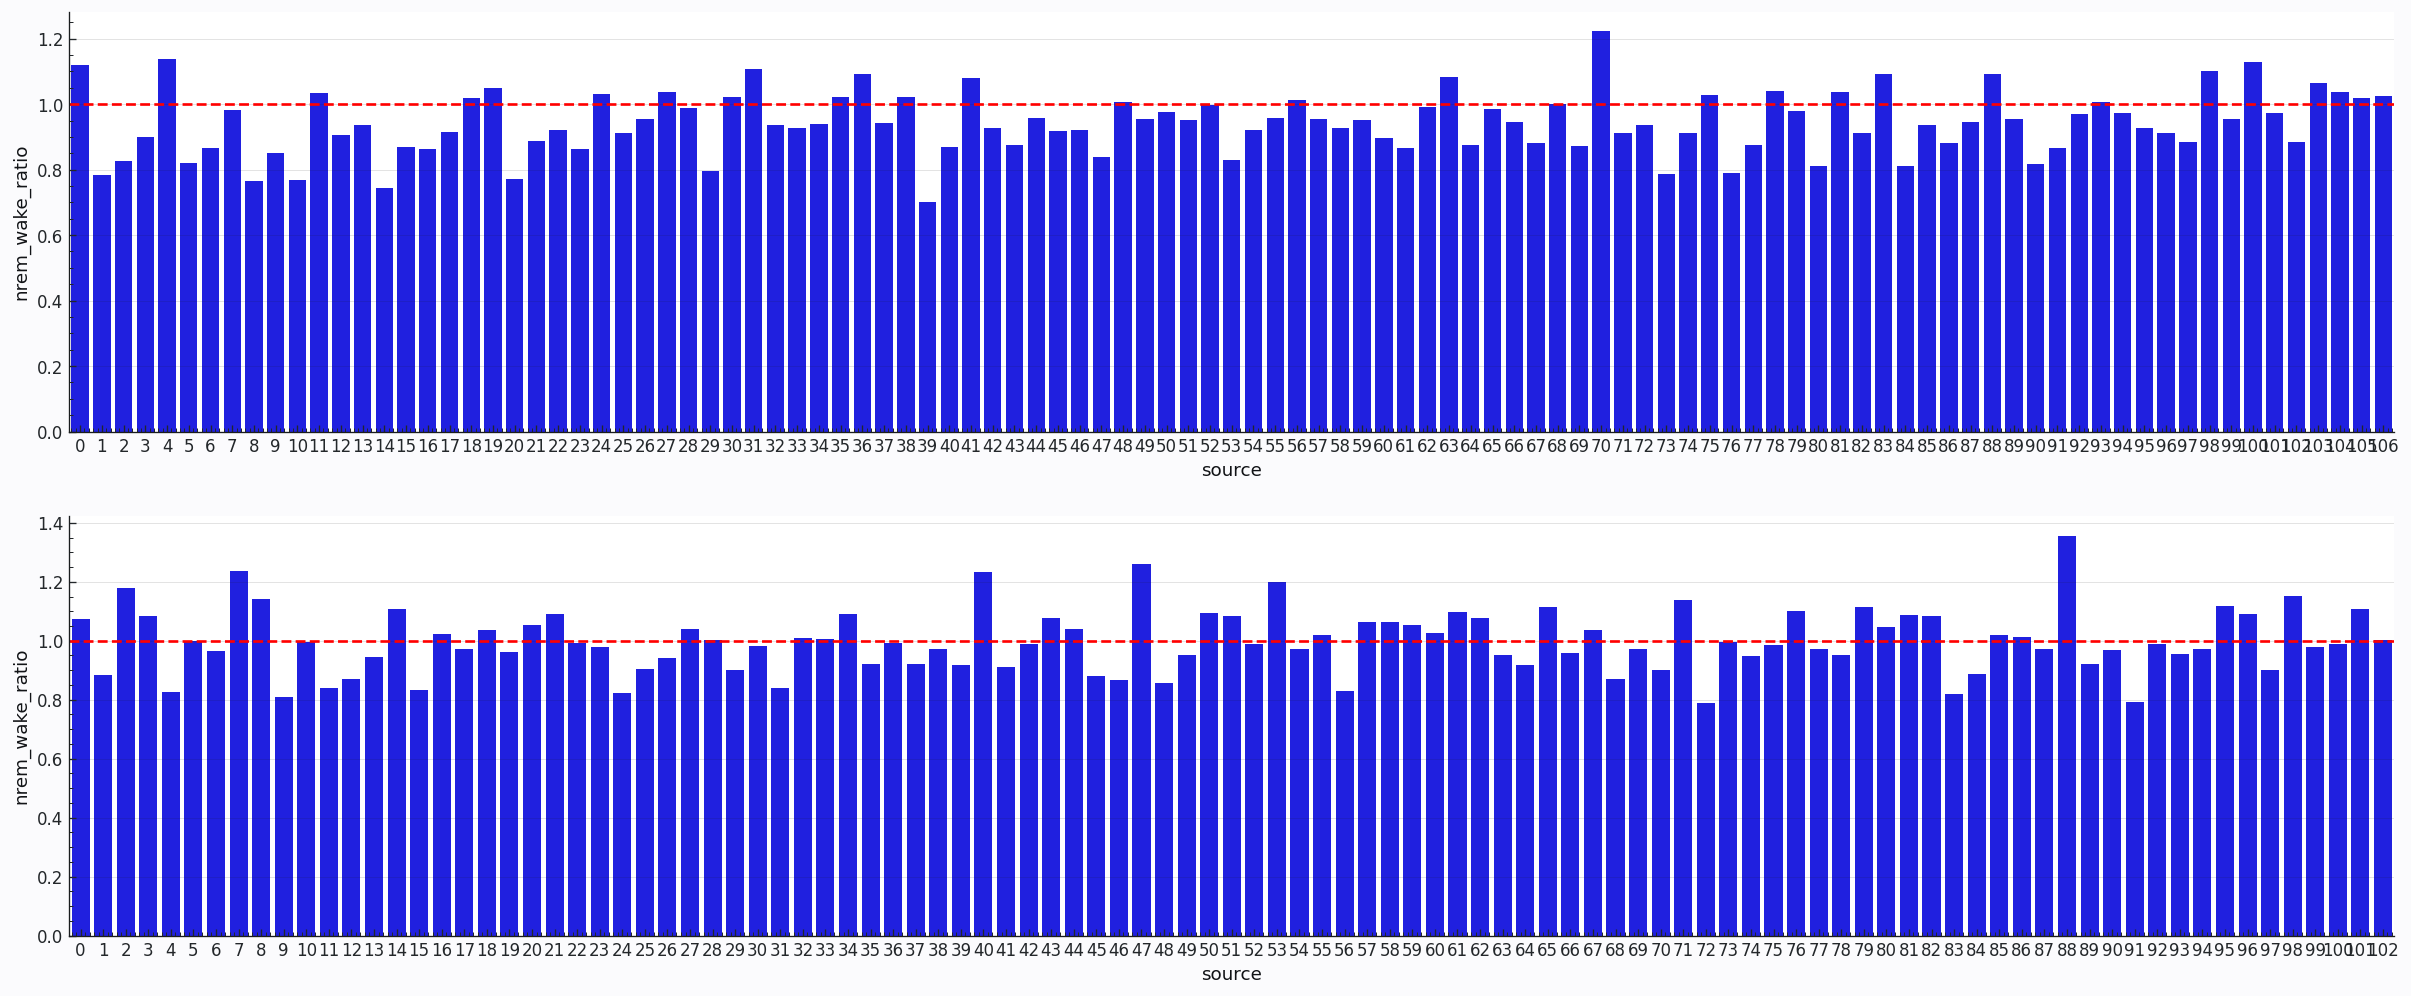

In [190]:
f, ax = plt.subplots(2, 1, figsize=(25, 10))
sns.barplot(data=sr.filter(pl.col('dmd')==1), x='source', y='nrem_wake_ratio', ax=ax[0], color='blue')
sns.barplot(data=sr.filter(pl.col('dmd')==2), x='source', y='nrem_wake_ratio', ax=ax[1], color='blue')
ax[0].axhline(1, color='red', linestyle='--')
ax[1].axhline(1, color='red', linestyle='--')

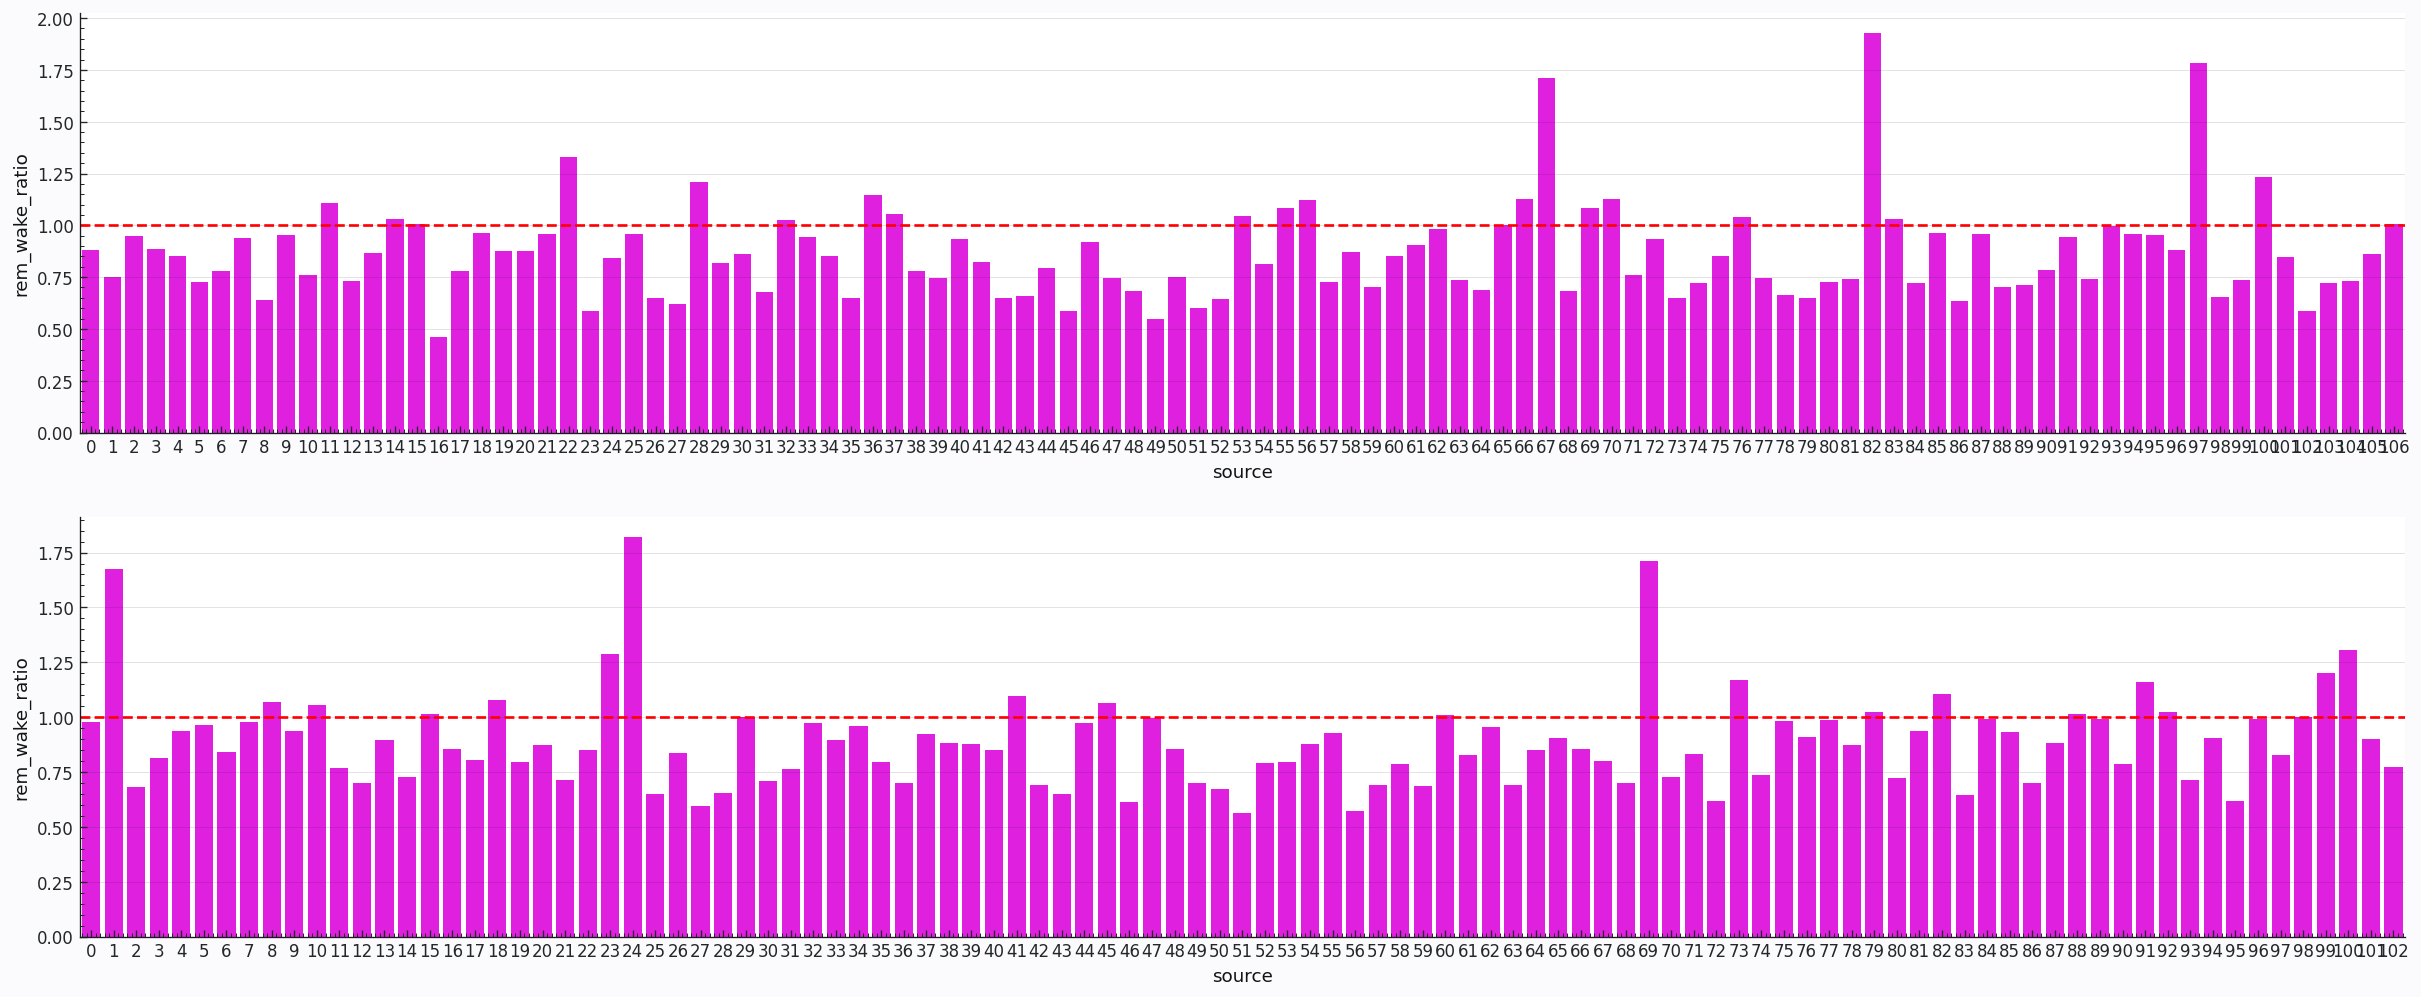

In [192]:
f, ax = plt.subplots(2, 1, figsize=(25, 10))
sns.barplot(data=sr.filter(pl.col('dmd')==1), x='source', y='rem_wake_ratio', ax=ax[0], color='magenta')
sns.barplot(data=sr.filter(pl.col('dmd')==2), x='source', y='rem_wake_ratio', ax=ax[1], color='magenta')
ax[0].axhline(1, color='red', linestyle='--')
ax[1].axhline(1, color='red', linestyle='--')

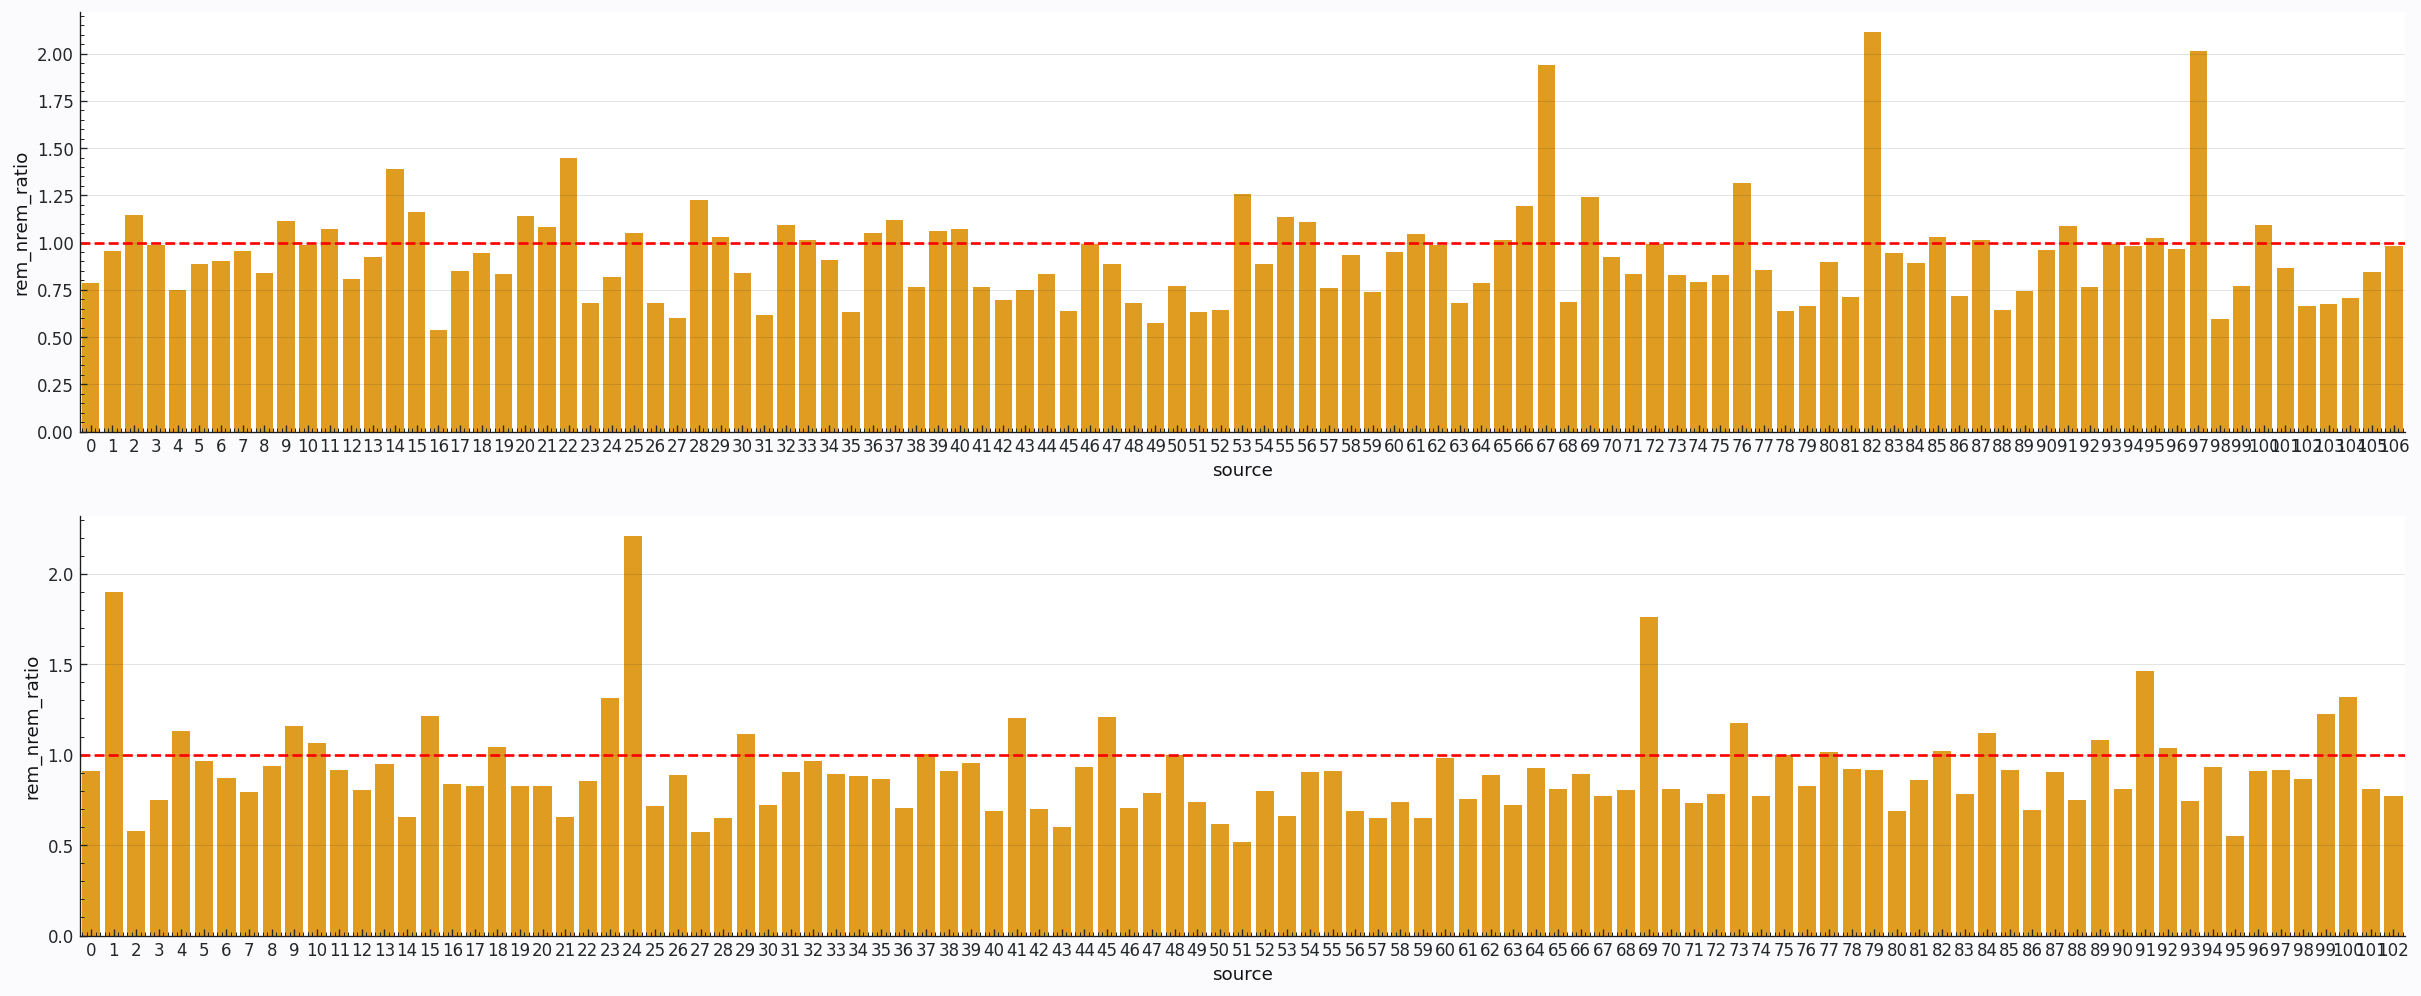

In [193]:
f, ax = plt.subplots(2, 1, figsize=(25, 10))
sns.barplot(data=sr.filter(pl.col('dmd')==1), x='source', y='rem_nrem_ratio', ax=ax[0], color='orange')
sns.barplot(data=sr.filter(pl.col('dmd')==2), x='source', y='rem_nrem_ratio', ax=ax[1], color='orange')
ax[0].axhline(1, color='red', linestyle='--')
ax[1].axhline(1, color='red', linestyle='--')